In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
customers =pd.read_csv("/kaggle/input/zeotap/Customers.csv")
products=pd.read_csv("/kaggle/input/zeotap/Products.csv")
transactions=pd.read_csv("/kaggle/input/zeotap/Transactions.csv")

In [3]:
# Merge datasets
data = pd.merge(transactions, customers, on='CustomerID')

# Feature Engineering
# Total spending, number of transactions, average transaction value
customer_features = data.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    transaction_count=('TransactionID', 'count'),
    avg_transaction_value=('TotalValue', 'mean'),
    region=('Region', 'first')
).reset_index()

In [4]:
# Encode categorical variable 'Region'
le = LabelEncoder()
customer_features['region_encoded'] = le.fit_transform(customer_features['region'])

# Select features for clustering
features = customer_features[['total_spent', 'transaction_count', 'avg_transaction_value', 'region_encoded']]

# Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [17]:
# Initialize lists to store results
k_values = range(3, 10)  # Test k from 3 to 9
db_scores = []
silhouette_scores = []

# Iterate over k values
for k in k_values:
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)
    
    # Calculate Davies-Bouldin Index and Silhouette Score
    db_index = davies_bouldin_score(scaled_features, clusters)
    silhouette_avg = silhouette_score(scaled_features, clusters)
    
    # Append results to lists
    db_scores.append(db_index)
    silhouette_scores.append(silhouette_avg)
    
    # Print results for each k
    print(f'k = {k}: DB Index = {db_index:.4f}, Silhouette Score = {silhouette_avg:.4f}')

# Find the best k based on Davies-Bouldin Index (minimize DBI)
best_k_db = k_values[db_scores.index(min(db_scores))]
best_db_score = min(db_scores)

# Find the best k based on Silhouette Score (maximize Silhouette Score)
best_k_silhouette = k_values[silhouette_scores.index(max(silhouette_scores))]
best_silhouette_score = max(silhouette_scores)

# Print the best k values
print(f'\nBest k based on Davies-Bouldin Index: k = {best_k_db} (DB Index = {best_db_score:.4f})')
print(f'Best k based on Silhouette Score: k = {best_k_silhouette} (Silhouette Score = {best_silhouette_score:.4f})')

# Store results in a DataFrame for visualization
results_df = pd.DataFrame({
    'k': k_values,
    'DB Index': db_scores,
    'Silhouette Score': silhouette_scores
})

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

k = 3: DB Index = 1.3298, Silhouette Score = 0.2505
k = 4: DB Index = 1.2323, Silhouette Score = 0.2702
k = 5: DB Index = 1.1397, Silhouette Score = 0.2784
k = 6: DB Index = 1.0636, Silhouette Score = 0.2929
k = 7: DB Index = 1.0347, Silhouette Score = 0.2852
k = 8: DB Index = 0.9795, Silhouette Score = 0.2827
k = 9: DB Index = 0.9848, Silhouette Score = 0.3031

Best k based on Davies-Bouldin Index: k = 8 (DB Index = 0.9795)
Best k based on Silhouette Score: k = 9 (Silhouette Score = 0.3031)


In [18]:
results_df

,k,DB Index,Silhouette Score
0,3,1.329780,0.250499
1,4,1.232277,0.270205
2,5,1.139725,0.278379
3,6,1.063615,0.292920
4,7,1.034679,0.285205
5,8,0.979509,0.282692
6,9,0.984836,0.303090


In [23]:
best_k_db

8

# For k=best_k_db(8)

In [19]:
# Clustering
optimal_clusters = best_k_db  # Adjust based on analysis
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_features)
customer_features['Cluster'] = clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [20]:
# Evaluate clustering
db_index = davies_bouldin_score(scaled_features, clusters)
silhouette_avg = silhouette_score(scaled_features, clusters)
print(f'DB Index: {db_index}')
print(f'Silhouette Score: {silhouette_avg}')

DB Index: 0.9795086644089563
Silhouette Score: 0.2826923803105371


In [26]:
# Visualize clusters
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)
customer_features['PCA1'] = pca_features[:, 0]
customer_features['PCA2'] = pca_features[:, 1]

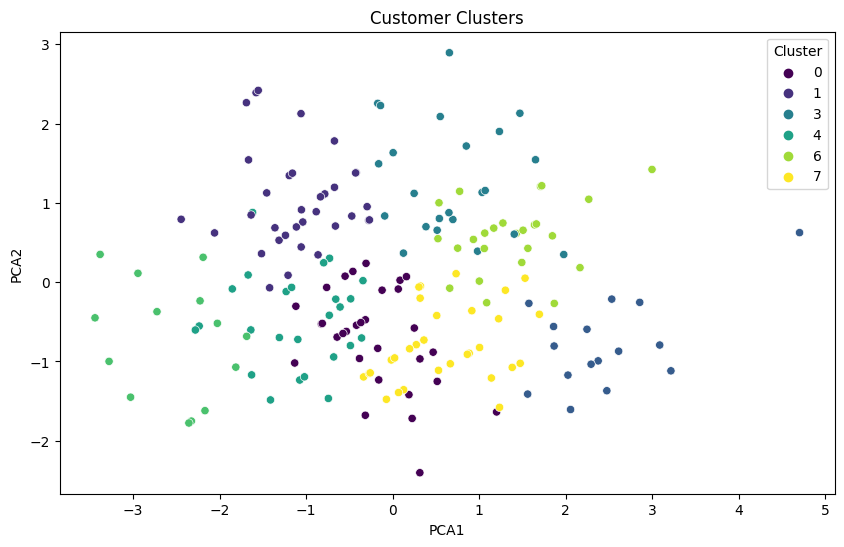

In [27]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', palette='viridis', data=customer_features
)
plt.title('Customer Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

# For k=3

In [28]:
# Clustering
optimal_clusters = 3 # Adjust based on analysis
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_features)
customer_features['Cluster'] = clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [29]:
# Evaluate clustering
db_index = davies_bouldin_score(scaled_features, clusters)
silhouette_avg = silhouette_score(scaled_features, clusters)
print(f'DB Index: {db_index}')
print(f'Silhouette Score: {silhouette_avg}')

DB Index: 1.3297804752635896
Silhouette Score: 0.25049931495580285


In [30]:
# Visualize clusters
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)
customer_features['PCA1'] = pca_features[:, 0]
customer_features['PCA2'] = pca_features[:, 1]

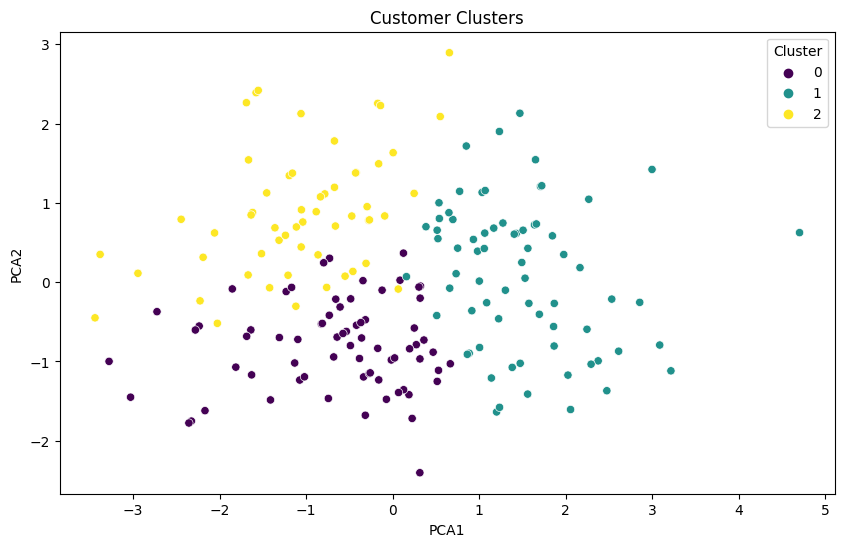

In [31]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', palette='viridis', data=customer_features
)
plt.title('Customer Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()